In [224]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd  
import numpy as np
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from adjustText import adjust_text
import matplotlib.cm as cm
import matplotlib.colors as mcolors

### Get the US County Polygon Data from the Census

In [225]:
county_shapes = gpd.read_file("/Users/nelsonfarrell/Documents/Northeastern/projects/hospital_beds/gis_data/cb_2023_us_county_500k.zip")

### Filter for Maine Counties

In [226]:
maine_counties = county_shapes[county_shapes.STATE_NAME == "Maine"].copy()

In [227]:
maine_counties.rename(columns = {"NAME":"county"}, inplace = True )

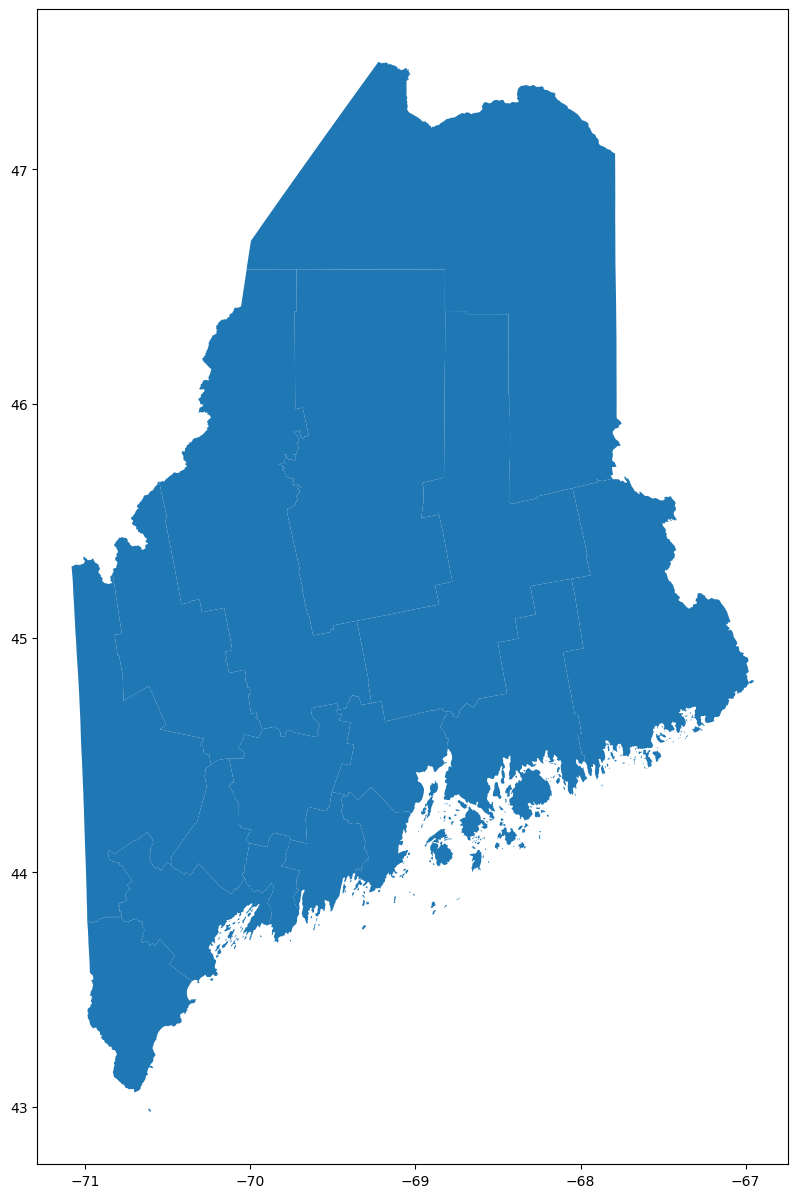

In [228]:
maine_counties.plot(figsize = (10, 15));

### Generate Regoin Mapping ~ Groups of Counties

In [229]:
region_map = {
                "Cumberland County" : 1,
                "York County" : 1,
                "Oxford County" : 2,
                "Kennebec County" : 3,
                "Knox County" : 4,
                "Lincoln County" : 4,
                "Somerset County": 3,
                "Washington County" : 7,
                "Hancock County" : 7,
                "Waldo County" : 4,
                "Penobscot County" : 6,
                "Aroostook County" : 5,
                "Piscataquis County" : 6,
                "Sagadahoc County" : 4,
                "Androscoggin County" : 3,
                "Franklin County": 2
              }

region_colors = {
                    1 : '#85c1e9',  # Light Blue
                    2 : '#c39bd3',  # Light Purple
                    3 : '#a3e4d7', # Light Green
                    4 : '#7dcea0',  # Light Red
                    5 : '#f8c471', # Light Orange
                    6 : "#f1948a", # Light Grey
                    7 : "#edbb99" # Light orange
                }

maine_counties.loc[:, "region"] = maine_counties["NAMELSAD"].map(region_map)
maine_counties.loc[:, "color"] = maine_counties["region"].map(region_colors)

/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_40597/2244587196.py:2: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  maine_counties.plot(column='region',


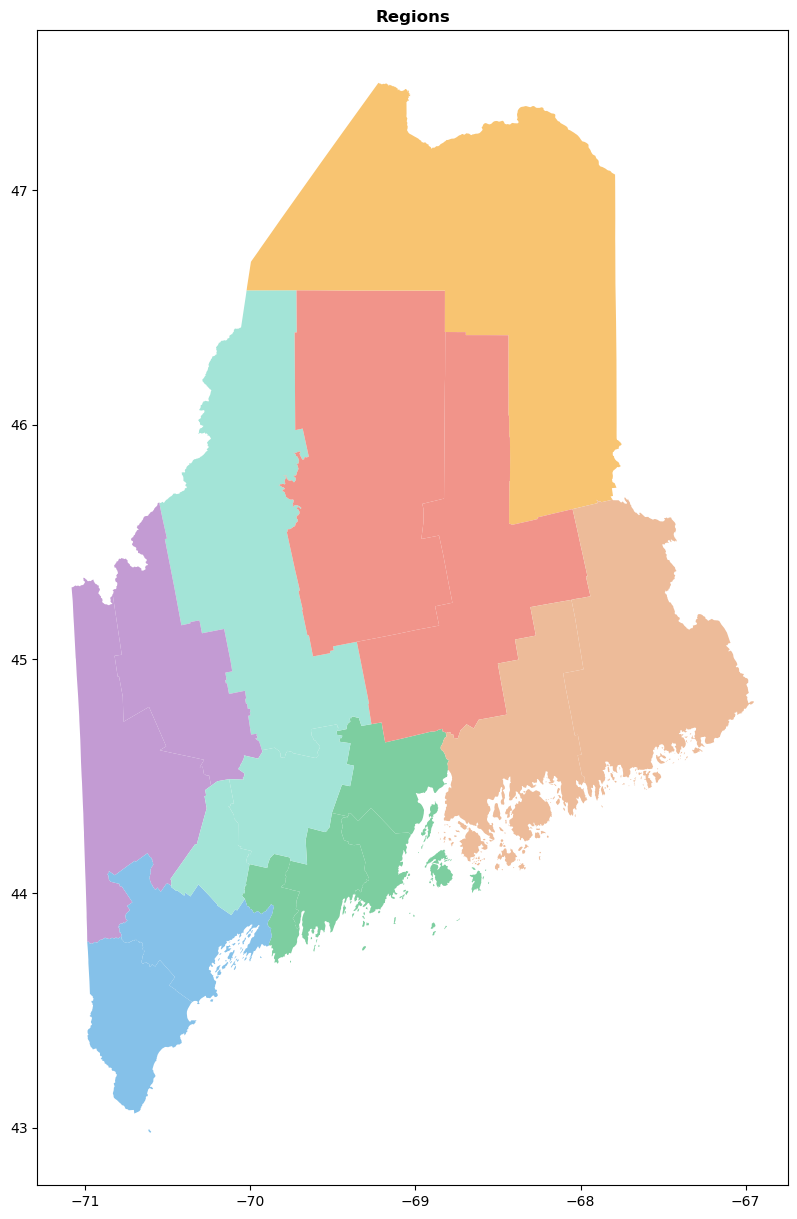

In [230]:
# Plot the map, coloring by region
maine_counties.plot(column='region', 
                   color = maine_counties["color"],  
                   legend = True,   
                   figsize=(10, 15))

plt.title("Regions", weight = "bold")
plt.show()


### Read In Hospital Response Data

In [231]:
response_data_full = pd.read_csv("/Users/nelsonfarrell/Documents/Northeastern/projects/hospital_beds/survey_data/CSV/response_data_dup_rows_removed.csv")

In [232]:
response_data = response_data_full[["13", "hospital_address"]].copy()

In [233]:
# First we have to remove this dumb parenthesis 
response_data["hospital_address"] = response_data["hospital_address"].str.rstrip(')')

# And the PO Box info, this messes up the geolocate function
response_data["hospital_address"] = response_data["hospital_address"].str.replace(r'P\.O\. Box \d+, ', '', regex=True)

In [234]:
# Now I have to drop stupid nans! We should both these dumb upstream! 
response_data = response_data.dropna(subset = "13")

### Inspect Hospital Name and Addresses

In [235]:
addresses = response_data.iloc[:, -1]
names = response_data.loc[:, "13"]
for name, address in zip(names, addresses):
    print(name," ---- ",  address)

Central Maine Medical Center  ----  300 Main Street, Lewiston, ME 04240
Penobscot Valley Hospital  ----  7 Transalpine Road, Lincoln, ME 04457
Franklin Memorial Hospital  ----  111 Franklin Health Commons, Farmington, ME 04938
Northern Light Mayo Hospital  ----  897 West Main Street, Dover-Foxcroft, ME 04426
Rumford Hospital  ----  420 Franklin Street, Rumford, ME 04276
Millinocket Regional Hospital  ----  200 Somerset Street, Millinocket, ME 04462
Northern Light Acadia Hospital  ----  268 Stillwater Avenue, Bangor, ME 04402-0422
Pen Bay Medical Center  ----  Six Glen Cove Drive, Rockport, ME 04856
Waldo County General Hospital  ----  118 Northport Avenue, Belfast, ME 04915
York Hospital  ----  15 Hospital Drive, York, ME 03909
Northern Light Mercy Hospital  ----  175 Fore River Parkway, Portland, ME 04102
Mid Coast Hospital  ----  123 Medical Center Drive, Brunswick, ME 04011
Mount Desert Island Hospital  ----  Bar Harbor, ME 04609-0008
Stephens Memorial Hospital  ----  181 Main Stree

### Get Lat & Long for Each Hospital

In [236]:
geolocator = Nominatim(user_agent = "my_geocoder")

lat_long_mapping_list = []
for name, address in zip(names, addresses):
    location = geolocator.geocode(address)
    if location != None:
        lat_long_mapping_list.append({
                                "hospital_name": name,
                                "lat": location.latitude,
                                "long": location.longitude
                                    })

    else:
        print(f"Location NOT found for {name}")        

Location NOT found for Northern Light Acadia Hospital
Location NOT found for Pen Bay Medical Center
Location NOT found for Mount Desert Island Hospital
Location NOT found for St. Joseph Hospital
Location NOT found for Southern Maine Health Care-Biddeford Campus
Location NOT found for Northern Light Eastern Maine Medical Center


In [237]:
lat_long_df = pd.DataFrame(lat_long_mapping_list)
lat_long_df

,hospital_name,lat,long
0,Central Maine Medical Center,44.102600,-70.214693
1,Penobscot Valley Hospital,45.347570,-68.517546
2,Franklin Memorial Hospital,44.626380,-70.162782
3,Northern Light Mayo Hospital,45.187687,-69.237320
4,Rumford Hospital,44.551582,-70.556172
5,Millinocket Regional Hospital,45.652969,-68.716155
6,Waldo County General Hospital,44.412666,-68.993824
7,York Hospital,43.142586,-70.651677
8,Northern Light Mercy Hospital,43.649556,-70.282933
9,Mid Coast Hospital,43.906566,-69.893015


### Add Lat & Long for Missing Hospitals

In [238]:
lat_long_manual = {"hospital_name": ["Northern Light Acadia Hospital", "Pen Bay Medical Center", "Mount Desert Island Hospital", 
                                     "St. Joseph Hospital", "Southern Maine Health Care-Biddeford Campus", "Northern Light Eastern Maine Medical Center"],
                   "lat": [44.820670, 44.143799, 44.384949, 44.814000, 43.477300, 44.80757],
                   "long": [-68.763830, -69.084862, -68.202187, -68.772570, -70.493010, -68.75246]}

lat_long_manual_df = pd.DataFrame(lat_long_manual)

In [239]:
hospital_lat_longs = pd.concat([lat_long_df, lat_long_manual_df], ignore_index = True)

In [240]:
hospital_lat_longs

,hospital_name,lat,long
0,Central Maine Medical Center,44.102600,-70.214693
1,Penobscot Valley Hospital,45.347570,-68.517546
2,Franklin Memorial Hospital,44.626380,-70.162782
3,Northern Light Mayo Hospital,45.187687,-69.237320
4,Rumford Hospital,44.551582,-70.556172
5,Millinocket Regional Hospital,45.652969,-68.716155
6,Waldo County General Hospital,44.412666,-68.993824
7,York Hospital,43.142586,-70.651677
8,Northern Light Mercy Hospital,43.649556,-70.282933
9,Mid Coast Hospital,43.906566,-69.893015


In [241]:
# Convert combined_df to GeoDataFrame
hospital_gdf = gpd.GeoDataFrame(
    hospital_lat_longs,
    geometry=[Point(xy) for xy in zip(hospital_lat_longs['long'], hospital_lat_longs['lat'])],
    crs='EPSG:4326')  # WGS84 CRS for latitude/longitude

/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_40597/492383138.py:6: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  maine_counties.plot(column='region',


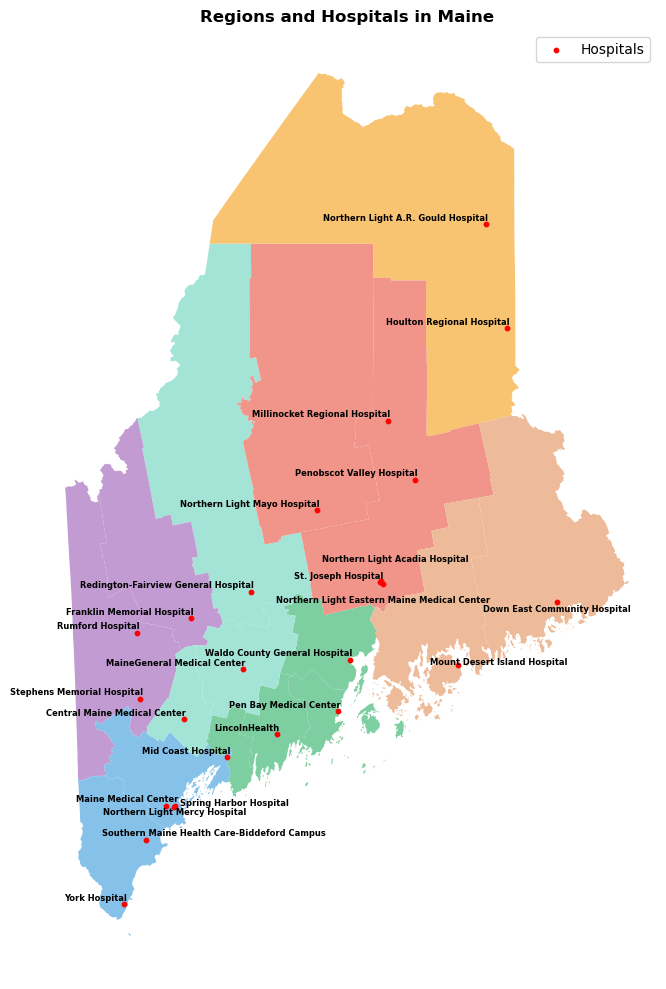

In [242]:
# Reproject hospital_gdf to match the CRS of maine_counties
hospital_gdf = hospital_gdf.to_crs(maine_counties.crs)

# Plot the regions
fig, ax = plt.subplots(figsize=(8, 13))
maine_counties.plot(column='region', 
                    color=maine_counties["color"],  
                    legend=True,   
                    ax=ax)

# Overlay the hospitals locations
hospital_gdf.plot(ax=ax, color='red', marker='o', label='Hospitals', markersize= 10)

# Add hospital names; adjusting alignment
for x, y, label in zip(hospital_gdf.geometry.x, hospital_gdf.geometry.y, hospital_gdf['hospital_name']):

    if label == "Northern Light Acadia Hospital":
        ax.text(x + 0.1, y + 0.1, label, fontsize=6, weight="bold", ha='center', color='black')  # Slightly shift to the right and up
        
    elif label == "Northern Light Eastern Maine Medical Center":
        ax.text(x, y - 0.1, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift down

    elif label == "Down East Community Hospital":
        ax.text(x, y - 0.05, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly down

    elif label == "Northern Light Mercy Hospital":
        ax.text(x, y - 0.04, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly down

    elif label == "Spring Harbor Hospital":
        ax.text(x + 0.5, y, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly right

    elif label == "Mount Desert Island Hospital":
        ax.text(x + 0.3, y, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly right

    elif label == "Southern Maine Health Care-Biddeford Campus":
        ax.text(x + 0.5, y + 0.02, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly right                                     
    else:       
        ax.text(x + 0.02, y + 0.02, label, fontsize=6, weight="bold", ha='right', color='black')

# Legend and title
plt.title("Regions and Hospitals in Maine", weight="bold")
ax.legend()
ax.axis("off")
plt.show();

### Map the Hospitals to Counties

In [243]:
# Maps the hospitals to their respective counties based on the lat and long
mapped_hospitals = gpd.sjoin(hospital_gdf, maine_counties, how = "left", predicate = "within")

In [244]:
mapped_hospitals.head()

,hospital_name,lat,long,geometry,index_right,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,county,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,region,color
0,Central Maine Medical Center,44.102600,-70.214693,POINT (-70.21469 44.10260),2626,23,001,00581286,0500000US23001,23001,Androscoggin,Androscoggin County,ME,Maine,06,1211995418,75541705,3,#a3e4d7
1,Penobscot Valley Hospital,45.347570,-68.517546,POINT (-68.51755 45.34757),1925,23,019,00581295,0500000US23019,23019,Penobscot,Penobscot County,ME,Maine,06,8798661091,414021728,6,#f1948a
2,Franklin Memorial Hospital,44.626380,-70.162782,POINT (-70.16278 44.62638),911,23,007,00581289,0500000US23007,23007,Franklin,Franklin County,ME,Maine,06,4395226704,121284631,2,#c39bd3
3,Northern Light Mayo Hospital,45.187687,-69.237320,POINT (-69.23732 45.18769),541,23,021,00581296,0500000US23021,23021,Piscataquis,Piscataquis County,ME,Maine,06,10258545867,1080517302,6,#f1948a
4,Rumford Hospital,44.551582,-70.556172,POINT (-70.55617 44.55158),52,23,017,00581294,0500000US23017,23017,Oxford,Oxford County,ME,Maine,06,5379294383,255884970,2,#c39bd3


In [245]:
mapped_hospitals.rename(columns = {"NAME": "county"}, inplace = True)

In [246]:
hospital_counties_and_region = mapped_hospitals[["hospital_name", "county", "region"]]

In [247]:
hospital_counties_and_region

,hospital_name,county,region
0,Central Maine Medical Center,Androscoggin,3
1,Penobscot Valley Hospital,Penobscot,6
2,Franklin Memorial Hospital,Franklin,2
3,Northern Light Mayo Hospital,Piscataquis,6
4,Rumford Hospital,Oxford,2
5,Millinocket Regional Hospital,Penobscot,6
6,Waldo County General Hospital,Waldo,4
7,York Hospital,York,1
8,Northern Light Mercy Hospital,Cumberland,1
9,Mid Coast Hospital,Cumberland,1


___
### Filter Response Data & Generate Grouped DF

In this section we can make some groupings and generate choropleths by region and by county.
The function below can make choropleths with data grouped by region and by county.

In [248]:
def generate_grouped_choropleth(grouped_df:pd.DataFrame, county_gis_df:pd.DataFrame, grouping_col:str, dissolve_flag:bool = False, setting_df:pd.DataFrame = None) -> None:
    """
    Genreates a choropleth using a grouped dataframe. 
    """
    # Get the grand total
    grand_total = int(grouped_df.sum())

    # Convert grouping_col to string; regions are currently ints
    maine_counties[grouping_col] = maine_counties[grouping_col].astype(str)
    grouped_df.index = grouped_df.index.astype(str)

    # Merge grouped_df and GIS df
    map_data = county_gis_df.merge(grouped_df, on = grouping_col, how = "left")

    # Genreate Choropleth
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    map_data.plot(column="total", cmap = "OrRd", linewidth = 0.8, ax = ax, edgecolor = "0.8", legend = False, alpha = 0.7)

    # If the dissolve flag is true, we generate new borders by region
    if dissolve_flag:

        # This changes the borders from county to region; the agg function makes it keep only one of the values,
        # rather than a sum. Since grouped_df already contains region totals, this is accurate.
        region_geometries = map_data.dissolve(by='region', aggfunc = {'total': 'first'})

        # Display totals in the center of the region
        for idx, row in region_geometries.iterrows():
            if not pd.isna(row['total']):  

                # Get the center of the region
                centroid = row['geometry'].centroid
                x, y = centroid.x, centroid.y
                ax.text(
                    x, y,
                    f"{int(row['total'])}",
                    ha="center", fontsize=10, color = "black", weight="bold"
                )                               
    # When the dissolve flag is false, we are grouping by county and keep the original boundaries.
    else:
        for idx, row in map_data.iterrows():
            if not pd.isna(row['total']):  

                # Get the center of the county
                centroid = row['geometry'].centroid
                x, y = centroid.x, centroid.y
                ax.text(
                    x, y,
                    f"{int(row['total'])}",
                    ha="center", fontsize=10, color="black", weight="bold"
                )      
    # Add the grand total to the bottom
    fig.text(
                0.5, 0.86,
                f"Statewide Total: {int(grand_total)}",
                ha = "center", 
                fontsize = 12, 
                color="black", 
                weight="bold"
            )
    if setting_df is not None:

        norm = mcolors.Normalize(vmin=setting_df["count"].min(), vmax=setting_df["count"].max())
        cmap = plt.colormaps["OrRd"]  # Use the modern way to get colormap
        colors = cmap(norm(setting_df["count"]))

        plt.subplots_adjust(bottom=0.2)
        ax2 = fig.add_axes([0.5, 0.15, 0.20, 0.1])  
        ax2.set_title("Totals by Destination", weight = "bold", style = "italic")
        bars = ax2.barh(setting_df.index, setting_df["count"], color = colors, alpha = 0.7)
        
        # Annotate bars
        for bar in bars:
            width = bar.get_width()  # Get the width of the bar
            y = bar.get_y() + bar.get_height() / 2  # Get the center of the bar
            ax2.text(
                width + 1, y,  # Position 
                f"{int(width)}",  # Annotation 
                va="center", ha="left", fontsize=10, fontweight="bold"
            )
        ax2.set_xticks([])
        ax2.tick_params(axis='y', length=0)
        plt.setp(ax2.get_yticklabels(), fontweight="bold")

    # Add title
    ax.set_title(f"Patients Awaiting Discharge by {grouping_col.capitalize()}", weight = "bold", fontsize = 16)
    ax.axis("off")

### Filter for Question # 1

In [249]:
# Filter for question # 1 ~ Totals
response_data_dropped_na_hos_name = response_data_full.dropna(subset = "13")
question_1_responses = response_data_dropped_na_hos_name.loc[:, ["13", "15", "16", "17", "18"]]
question_1_responses

,13,15,16,17,18
1,Central Maine Medical Center,3.0,3.0,1.0,5.0
3,Penobscot Valley Hospital,0.0,0.0,0.0,1.0
4,Franklin Memorial Hospital,NaN,2.0,1.0,NaN
5,Northern Light Mayo Hospital,NaN,NaN,NaN,NaN
6,Rumford Hospital,NaN,NaN,NaN,NaN
7,Millinocket Regional Hospital,1.0,0.0,0.0,3.0
8,Northern Light Acadia Hospital,NaN,NaN,NaN,NaN
9,Pen Bay Medical Center,4.0,5.0,4.0,2.0
10,Waldo County General Hospital,3.0,3.0,1.0,2.0
11,York Hospital,3.0,1.0,0.0,0.0


In [250]:
question_1_responses["total"] = question_1_responses.iloc[:, 1:5].sum(axis = 1, skipna = True)

In [251]:
settings_totals = question_1_responses.sum(axis = 0)

In [252]:
setting_df = pd.DataFrame(settings_totals).loc[["15", "16", "17", "18"], :]

In [253]:
setting_df.index = ["SNF", "LTF", "RCF", "HH"]

In [254]:
setting_df.rename(columns = {0:"count"}, inplace = True)

In [255]:
setting_df

,count
SNF,108.0
LTF,78.0
RCF,38.0
HH,74.0


In [256]:
setting_df["count"] = pd.to_numeric(setting_df["count"], errors="coerce")


In [257]:
question_1_responses = question_1_responses[["13", "total"]]

In [258]:
question_1_responses_with_counties = question_1_responses.merge(hospital_counties_and_region, left_on = "13", right_on = "hospital_name")

In [259]:
question_1_responses_with_counties.rename(columns = {"NAME": "county"}, inplace = True)

### Group Question # 1 by Region

In [260]:
grouped_by_region_df = question_1_responses_with_counties.groupby("region")["total"].sum()
grouped_by_region_df

region
1    118.0
2      3.0
3     40.0
4     27.0
5      9.0
6     91.0
7     10.0
Name: total, dtype: float64

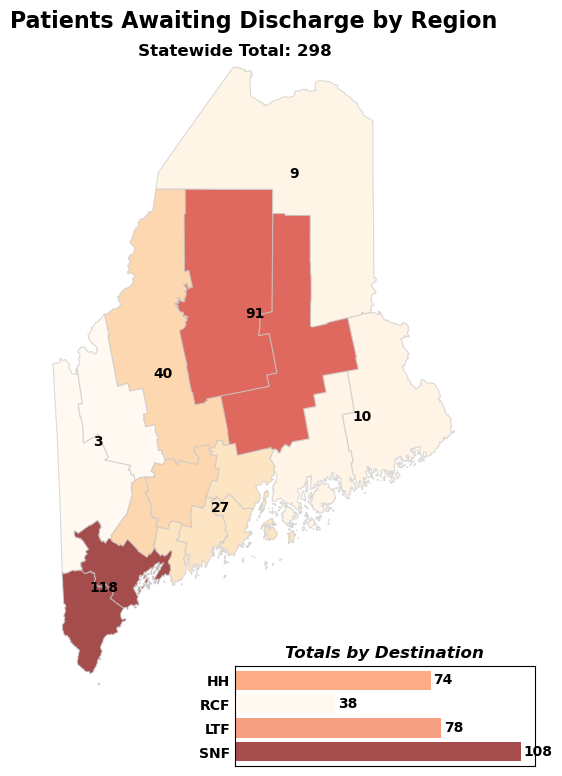

In [261]:
generate_grouped_choropleth(grouped_by_region_df, maine_counties, "region", True, setting_df)

### Group Question # 1 by County

In [262]:
grouped_by_region_df = question_1_responses_with_counties.groupby("county")["total"].sum()
grouped_by_region_df

county
Androscoggin     12.0
Aroostook         9.0
Cumberland      114.0
Franklin          3.0
Hancock           5.0
Kennebec         22.0
Knox             15.0
Lincoln           3.0
Oxford            0.0
Penobscot        91.0
Piscataquis       0.0
Somerset          6.0
Waldo             9.0
Washington        5.0
York              4.0
Name: total, dtype: float64

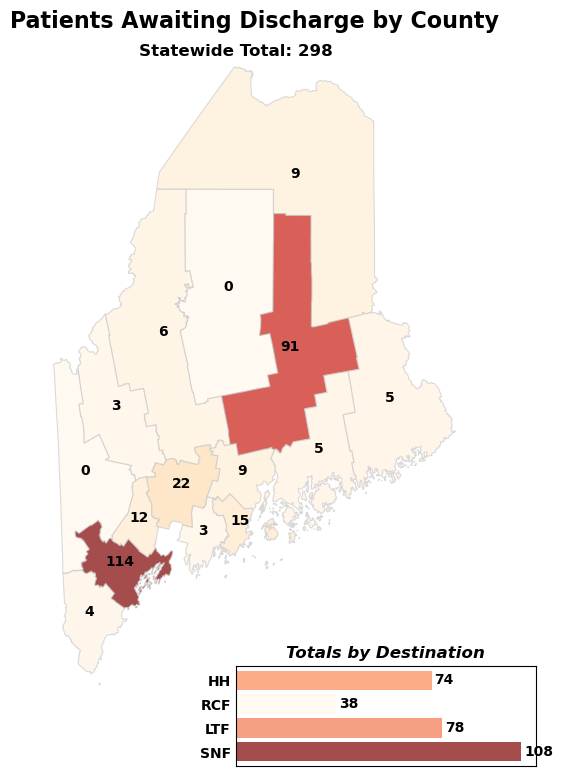

In [263]:
generate_grouped_choropleth(grouped_by_region_df, maine_counties, "county", False, setting_df)

In [265]:
question_1_responses

,13,total
1,Central Maine Medical Center,12.0
3,Penobscot Valley Hospital,1.0
4,Franklin Memorial Hospital,3.0
5,Northern Light Mayo Hospital,0.0
6,Rumford Hospital,0.0
7,Millinocket Regional Hospital,4.0
8,Northern Light Acadia Hospital,0.0
9,Pen Bay Medical Center,15.0
10,Waldo County General Hospital,9.0
11,York Hospital,4.0


In [268]:
mapped_hospitals

mapped_hos_with_q1 = mapped_hospitals.merge(question_1_responses, left_on = "hospital_name", right_on = "13")

/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_40597/3870514005.py:14: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  maine_counties.plot(


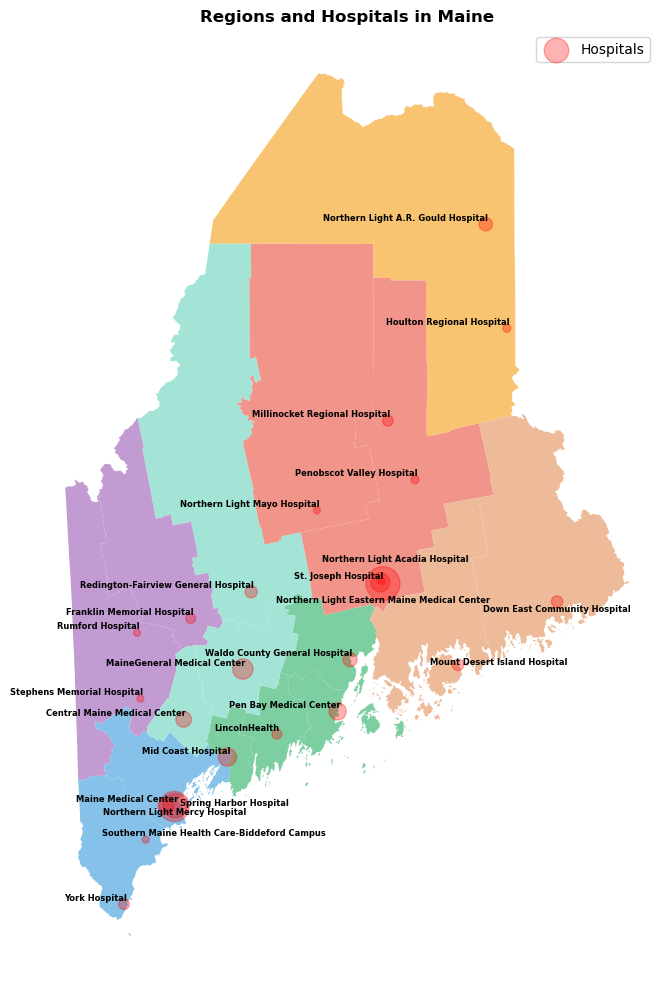

In [278]:
# Reproject hospital_gdf to match the CRS of maine_counties
hospital_gdf = hospital_gdf.to_crs(maine_counties.crs)

# Normalize the marker size column for consistent scaling
size_min, size_max = 25, 600  # Minimum and maximum marker sizes; this is kinda arbitrary
hospital_gdf["scaled_size"] = (
    (hospital_gdf["total"] - hospital_gdf["total"].min())
    / (hospital_gdf["total"].max() - hospital_gdf["total"].min())
    * (size_max - size_min) + size_min
)

# Plot the regions
fig, ax = plt.subplots(figsize=(8, 13))
maine_counties.plot(
    column='region', 
    color=maine_counties["color"],  
    legend=True,   
    ax=ax
)

# Overlay the hospital locations with semi-transparent markers and variable sizes
hospital_gdf.plot(
    ax=ax, 
    color='red', 
    marker='o', 
    label='Hospitals', 
    markersize=hospital_gdf["scaled_size"], 
    alpha=0.3  
)

# Add hospital names; adjusting alignment
for x, y, label in zip(hospital_gdf.geometry.x, hospital_gdf.geometry.y, hospital_gdf['hospital_name']):

    if label == "Northern Light Acadia Hospital":
        ax.text(x + 0.1, y + 0.1, label, fontsize=6, weight="bold", ha='center', color='black')  # Slightly shift to the right and up
        
    elif label == "Northern Light Eastern Maine Medical Center":
        ax.text(x, y - 0.1, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift down

    elif label == "Down East Community Hospital":
        ax.text(x, y - 0.05, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly down

    elif label == "Northern Light Mercy Hospital":
        ax.text(x, y - 0.04, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly down

    elif label == "Spring Harbor Hospital":
        ax.text(x + 0.5, y, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly right

    elif label == "Mount Desert Island Hospital":
        ax.text(x + 0.3, y, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly right

    elif label == "Southern Maine Health Care-Biddeford Campus":
        ax.text(x + 0.5, y + 0.02, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly right                                     
    else:       
        ax.text(x + 0.02, y + 0.02, label, fontsize=6, weight="bold", ha='right', color='black')

# Legend and title
plt.title("Regions and Hospitals in Maine", weight="bold")
ax.legend()
ax.axis("off")
plt.show()


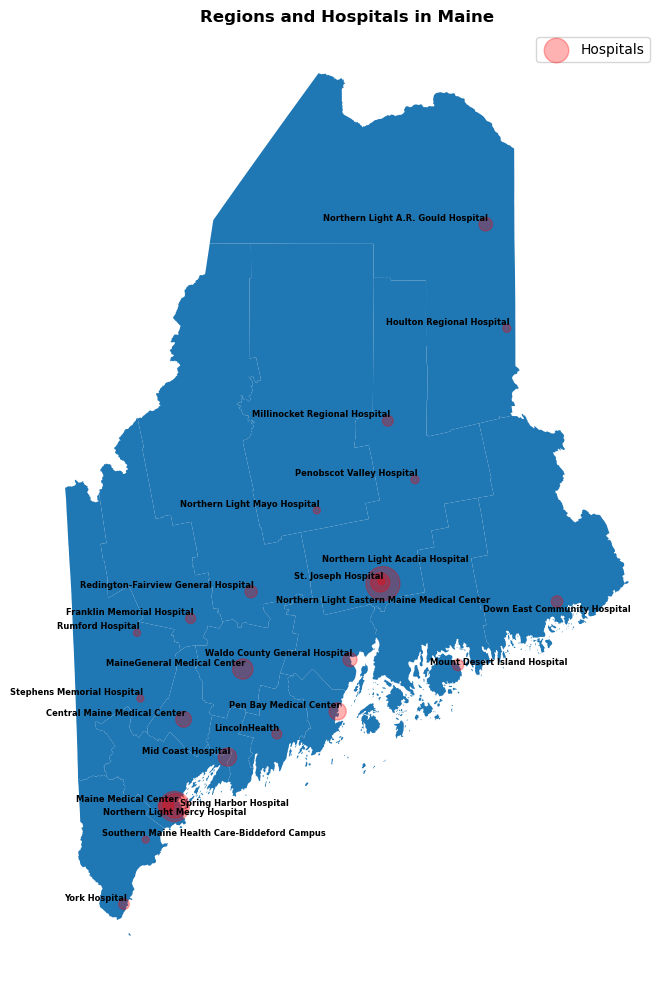

In [279]:
# Reproject hospital_gdf to match the CRS of maine_counties
hospital_gdf = hospital_gdf.to_crs(maine_counties.crs)

# Normalize the marker size column for consistent scaling
size_min, size_max = 25, 600  # Minimum and maximum marker sizes
hospital_gdf["scaled_size"] = (
    (hospital_gdf["total"] - hospital_gdf["total"].min())
    / (hospital_gdf["total"].max() - hospital_gdf["total"].min())
    * (size_max - size_min) + size_min
)

# Plot the regions
fig, ax = plt.subplots(figsize=(8, 13))
maine_counties.plot(ax=ax
)

# Overlay the hospital locations
hospital_gdf.plot(
    ax=ax, 
    color='red', 
    marker='o', 
    label='Hospitals', 
    markersize=hospital_gdf["scaled_size"], 
    alpha=0.3  
)

# Add hospital names; adjusting alignment
for x, y, label in zip(hospital_gdf.geometry.x, hospital_gdf.geometry.y, hospital_gdf['hospital_name']):

    if label == "Northern Light Acadia Hospital":
        ax.text(x + 0.1, y + 0.1, label, fontsize=6, weight="bold", ha='center', color='black')  # Slightly shift to the right and up
        
    elif label == "Northern Light Eastern Maine Medical Center":
        ax.text(x, y - 0.1, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift down

    elif label == "Down East Community Hospital":
        ax.text(x, y - 0.05, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly down

    elif label == "Northern Light Mercy Hospital":
        ax.text(x, y - 0.04, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly down

    elif label == "Spring Harbor Hospital":
        ax.text(x + 0.5, y, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly right

    elif label == "Mount Desert Island Hospital":
        ax.text(x + 0.3, y, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly right

    elif label == "Southern Maine Health Care-Biddeford Campus":
        ax.text(x + 0.5, y + 0.02, label, fontsize=6, weight="bold", ha='center', color='black')  # Shift slightly right                                     
    else:       
        ax.text(x + 0.02, y + 0.02, label, fontsize=6, weight="bold", ha='right', color='black')

# Legend and title
plt.title("Regions and Hospitals in Maine", weight="bold")
ax.legend()
ax.axis("off")
plt.show()

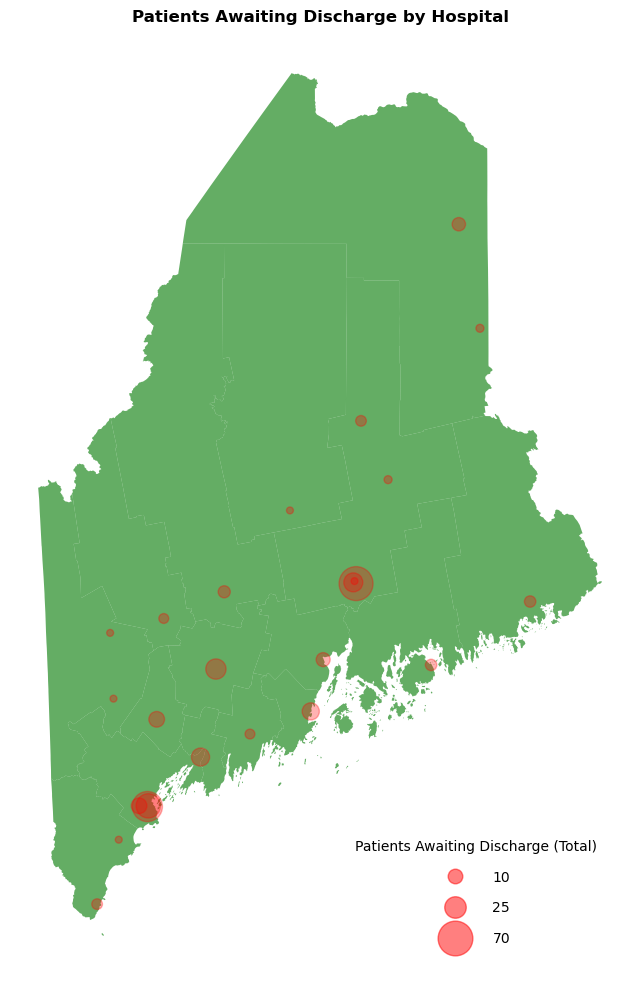

In [303]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Reproject hospital_gdf to match the CRS of maine_counties
hospital_gdf = hospital_gdf.to_crs(maine_counties.crs)

# Normalize the marker size column for consistent scaling
size_min, size_max = 25, 600  # Minimum and maximum marker sizes
hospital_gdf["scaled_size"] = (
    (hospital_gdf["total"] - hospital_gdf["total"].min())
    / (hospital_gdf["total"].max() - hospital_gdf["total"].min())
    * (size_max - size_min) + size_min
)

# Plot the regions
fig, ax = plt.subplots(figsize=(8, 13))
maine_counties.plot(ax=ax, color="forestgreen", alpha=0.7)

# Overlay the hospital locations with semi-transparent markers and variable sizes
hospital_gdf.plot(
    ax=ax,
    color='red',
    marker='o',
    markersize=hospital_gdf["scaled_size"],
    alpha=0.3
)

# Add a custom legend for dot sizes
reference_totals = [10, 25, 70]  # Example hospital "total" values
reference_sizes = [
    (total - hospital_gdf["total"].min())
    / (hospital_gdf["total"].max() - hospital_gdf["total"].min())
    * (size_max - size_min) + size_min
    for total in reference_totals
]

# Create legend handles with adjusted sizes for the legend box
handles = [
    mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                  markersize=size**0.5, alpha=0.5, label=f'{total}')
    for total, size in zip(reference_totals, reference_sizes)
]

# Add the legend
legend = ax.legend(
    handles=handles, 
    title="Patients Awaiting Discharge (Total)", 
    loc='lower right', 
    frameon=False, 
    borderpad=1.9,  # Increase padding inside the legend box
    labelspacing=1.2,  # Increase space between labels
    handletextpad=1.7,  # Increase space between markers and text
    fontsize=10  # Adjust font size for better fit
)

# Title and axis adjustments
plt.title("Patients Awaiting Discharge by Hospital", weight="bold")
ax.axis("off")

plt.show()


